In [7]:
# Imports
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nba_utils.call_API import get_games_data
from nba_utils.call_API import get_boxscores
from nba_utils.call_API import tidy_axes
from nba_utils.call_API import get_pbp
from nba_utils.call_API import compute_time_axis

from scipy.interpolate import interp1d

# Show all contents of DataFrames and Series
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Constants for figure visualization
GOLDEN_RATIO = 1.618
HEIGHT = 12
WIDTH = HEIGHT*GOLDEN_RATIO

MIDNIGHT_BLUE = "#0e2240"
SUNSHINE_YELLOW = "#fec524"
FLATIRONS_RED = "#8b2131"

In [10]:
# Constant variables to be used throughout analysis
NUGGETS_ID = 1610612743 # team ID for Denver Nuggets
NETS_ID = 1610612751    # team ID for Brooklyn Nets

LAST_SEASON = "2024-25" # string for last NBA season
THIS_SEASON = "2025-26" # string for this NBA season

# Games played so far this year
GAMES_PLAYED = 21

In [11]:
# Get game data
nuggetsGames = get_games_data(THIS_SEASON, NUGGETS_ID)
netsGames = get_games_data(LAST_SEASON, NETS_ID)

In [12]:
# Show the games data for one team.
nuggetsGames.tail()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
5,22025,1610612743,DEN,Denver Nuggets,0022500287,2025-11-24,DEN @ MEM,W,240,125,46,91,0.505,22,43,0.512,11,14,0.786,14,32,46,32,5,3,14,15,10.0
4,22025,1610612743,DEN,Denver Nuggets,0022500076,2025-11-28,DEN vs. SAS,L,241,136,48,91,0.527,16,39,0.410,24,30,0.800,14,30,44,27,5,5,16,22,-3.0
3,22025,1610612743,DEN,Denver Nuggets,0022500299,2025-11-29,DEN @ PHX,W,238,130,44,76,0.579,22,38,0.579,20,21,0.952,10,30,40,36,2,5,16,20,18.0
2,22025,1610612743,DEN,Denver Nuggets,0022500315,2025-12-01,DEN vs. DAL,L,241,121,47,99,0.475,12,37,0.324,15,18,0.833,12,35,47,37,5,5,7,11,-10.0
1,22025,1610612743,DEN,Denver Nuggets,0022500325,2025-12-03,DEN @ IND,W,240,135,49,83,0.590,17,28,0.607,20,26,0.769,5,33,38,23,6,5,10,21,15.0


In [13]:
# Cam Johnson's box score for every game so far in Denver Nuggets
camBoxNugs = get_boxscores(nuggetsGames["GAME_ID"], "cameron-johnson", "traditional")
camBoxNets = get_boxscores(netsGames["GAME_ID"], "cameron-johnson", "traditional")

In [14]:
# Note that Cam missed one game, against Wolves on 11/15, so there's one less row in the DataFrame than in nuggetsGames
camBoxNugs.head()

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,playerSlug,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,GAME_ID
1,0022500006,1610612743,Denver,Nuggets,DEN,nuggets,1629661,Cameron,Johnson,C. Johnson,cameron-johnson,F,,,32:01,2,8,0.250,1,6,0.167,0,0,0.0,0,3,3,2,1,0,1,3,5,-17.0,0022500006
2,0022500104,1610612743,Denver,Nuggets,DEN,nuggets,1629661,Cameron,Johnson,C. Johnson,cameron-johnson,F,,,24:39,4,9,0.444,1,3,0.333,6,6,1.0,2,2,4,1,1,0,0,3,15,15.0,0022500104
3,0022500008,1610612743,Denver,Nuggets,DEN,nuggets,1629661,Cameron,Johnson,C. Johnson,cameron-johnson,F,,,18:56,2,5,0.400,1,3,0.333,0,0,0.0,0,2,2,2,0,0,2,5,5,-14.0,0022500008
4,0022500134,1610612743,Denver,Nuggets,DEN,nuggets,1629661,Cameron,Johnson,C. Johnson,cameron-johnson,F,,,27:15,2,4,0.500,2,4,0.500,1,2,0.5,0,1,1,1,0,0,1,2,7,22.0,0022500134
5,0022500026,1610612743,Denver,Nuggets,DEN,nuggets,1629661,Cameron,Johnson,C. Johnson,cameron-johnson,F,,,31:06,3,7,0.429,1,3,0.333,2,2,1.0,0,6,6,1,0,1,0,2,9,14.0,0022500026


In [15]:
# Convert minutes from MIN:SEC to float minutes. e.g., 5:30 to 5.5. Add -1 if no minutes played.
camBoxNugs["floatMinutes"] = camBoxNugs["minutes"].apply(lambda x: float(x.split(":")[0])+float(x.split(":")[1])/60 if x else -1)
camBoxNets["floatMinutes"] = camBoxNets["minutes"].apply(lambda x: float(x.split(":")[0])+float(x.split(":")[1])/60 if x else -1)

# Filter out games where he didn't play
camBoxNets = camBoxNets[camBoxNets["floatMinutes"] != -1]
camBoxNugs = camBoxNugs[camBoxNugs["floatMinutes"] != -1]

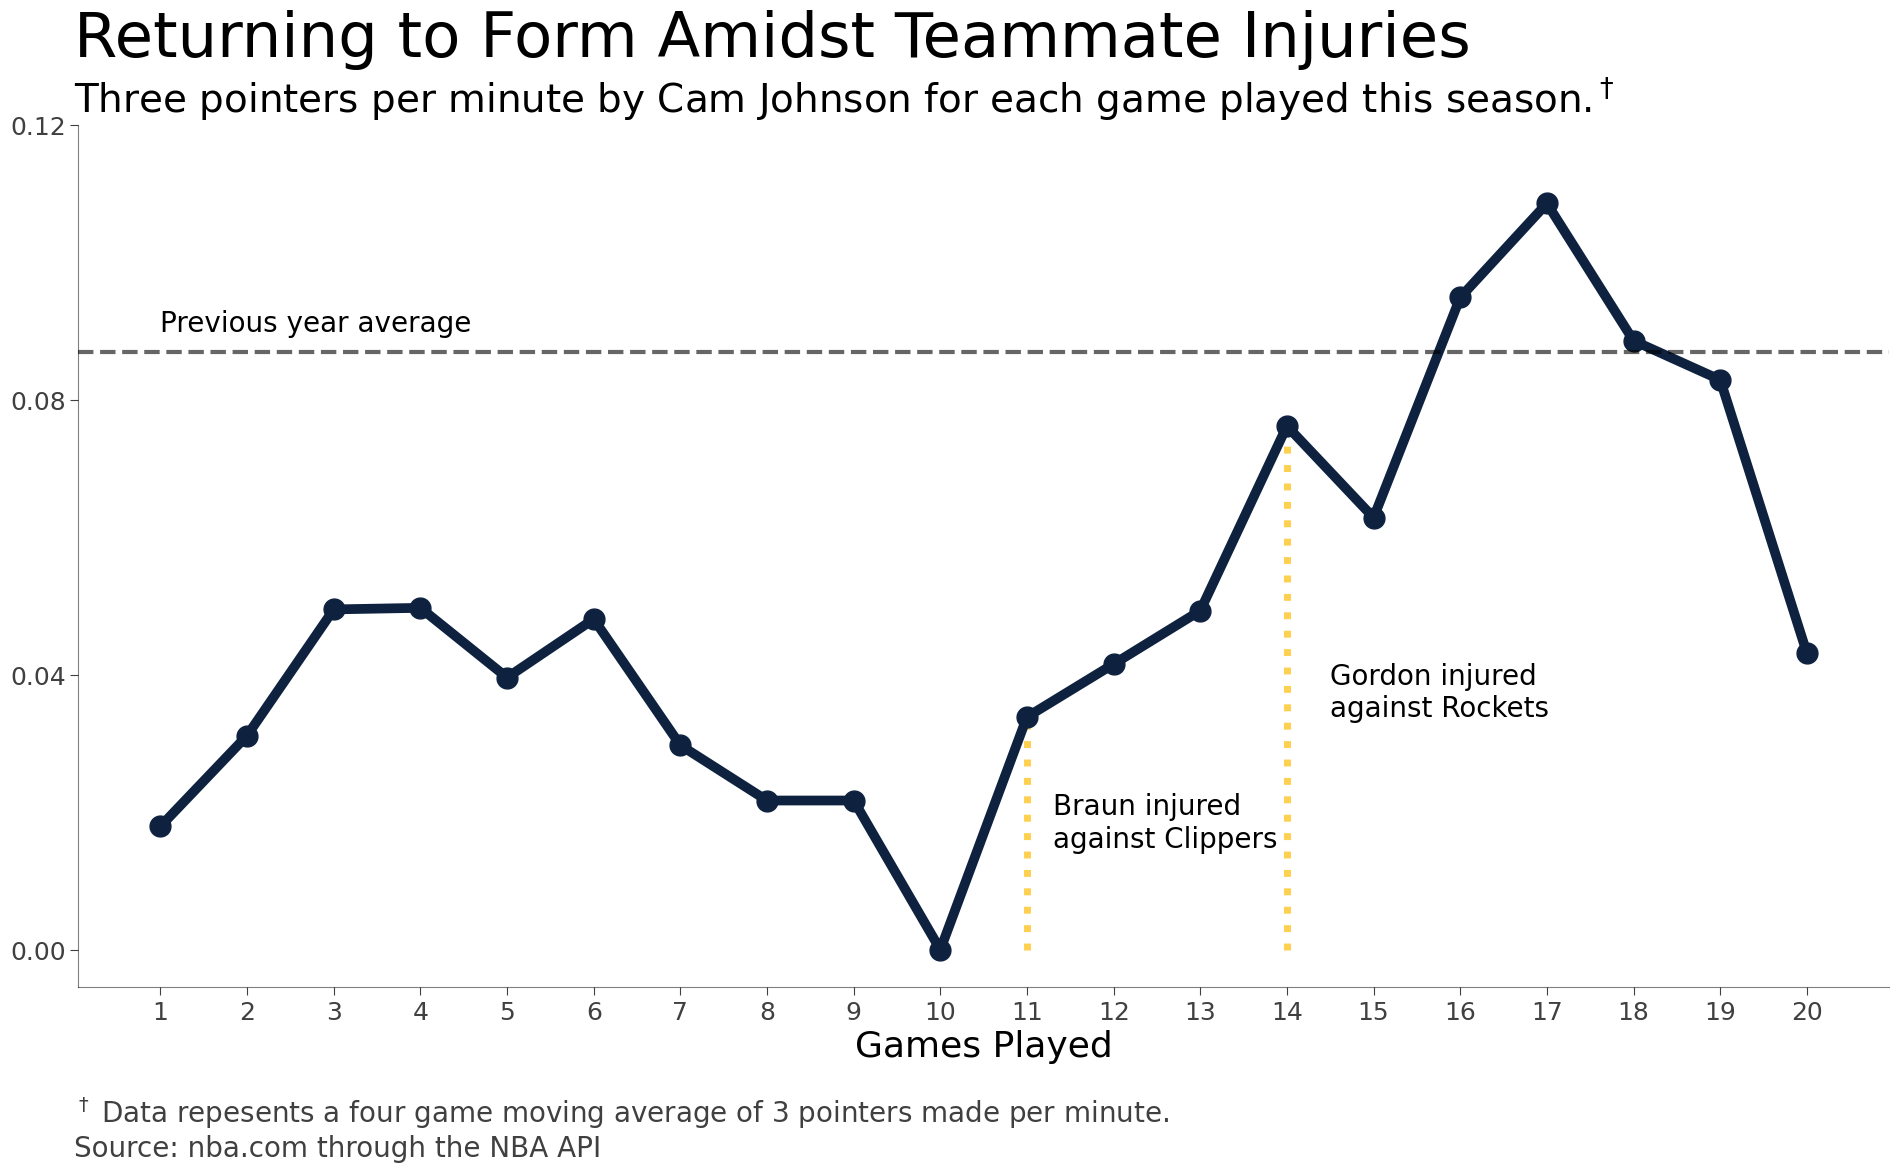

In [16]:
# Create figure for points/minutes Cam Johnson this year and last
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

# Plot 3s made per minutes played
threes = camBoxNugs["threePointersMade"]/camBoxNugs["floatMinutes"]
# ax.plot(camBoxNugs.index, threes, alpha=0.3, color=MIDNIGHT_BLUE, label="Three pointers made per minute")

# Smooth the data
box_length = 4
ynew = smooth(threes, box_length)
ax.plot(camBoxNugs.index, ynew, color=MIDNIGHT_BLUE, linewidth=7, marker="o", markersize=15)

# Show last year average 3s/minute
threes_avg = np.mean(camBoxNets["threePointersMade"]/camBoxNets["floatMinutes"])

ax.axhline(threes_avg, color="k", linestyle="dashed", linewidth=3, alpha=0.6) # Net's average
ax.vlines(11, 0, ynew[10], color=SUNSHINE_YELLOW, linewidth=5, linestyle="dotted", zorder=0, alpha=0.8)
ax.vlines(14, 0, ynew[13], color=SUNSHINE_YELLOW, linewidth=5, linestyle="dotted", zorder=0, alpha=0.8)

# Format axes
tidy_axes(ax)
ax.set_xticks(camBoxNugs.index)
ax.set_xticklabels(camBoxNugs.index, fontsize=18)
ylabels = np.linspace(0, 0.12, 4)
ax.set_yticks(ylabels)
ax.set_yticklabels([f"{lab:0.2f}" for lab in ylabels], fontsize=18)

ax.set_xlabel("Games Played", fontsize=26)

# Injury annotations
ax.text(11.3, 0.015, "Braun injured\nagainst Clippers", fontsize=20)
ax.text(14.5, 0.034, "Gordon injured\nagainst Rockets", fontsize=20)

# Annotate horizontal line
ax.text(1, 0.090, "Previous year average", fontsize=20)

# Title and subtitle
ax.text(0, 0.130, "Returning to Form Amidst Teammate Injuries", fontsize=45)
ax.text(0, 0.122, r"Three pointers per minute by Cam Johnson for each game played this season.$^\dagger$", fontsize=28)

# Footer
ax.text(0, -0.025, r"$^\dagger$ Data repesents a four game moving average of 3 pointers made per minute.", fontsize=20, color=(0,0,0,.75))
ax.text(0, -0.030, "Source: nba.com through the NBA API", fontsize=20, color=(0,0,0,.75))

plt.tight_layout()
# plt.savefig("johnson_threes_updated.png")
plt.show()

---
## Now get data for Spencer Jones

In [17]:
jonesBoxNugs = get_boxscores(nuggetsGames["GAME_ID"], "spencer-jones", "traditional")
jonesBoxNugs["floatMinutes"] = jonesBoxNugs["minutes"].apply(lambda x: float(x.split(":")[0])+float(x.split(":")[1])/60 if x else -1)

In [18]:
jonesBoxNugs

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,playerSlug,position,comment,jerseyNum,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,GAME_ID,floatMinutes
1,0022500006,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,,,5:47,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,1,0,1,0,0,5.0,0022500006,5.783333
2,0022500104,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,,,3:13,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,1,0,1,0,0,0.0,0022500104,3.216667
3,0022500008,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,,,0:20,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,1,0,-4.0,0022500008,0.333333
4,0022500134,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,,,5:43,1,3,0.333,0,2,0.000,0,0,0.0,1,0,1,0,0,0,2,2,2,-5.0,0022500134,5.716667
5,0022500026,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,DNP - Coach's Decision,,,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0022500026,-1.000000
6,0022500162,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,DNP - Coach's Decision,,,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0022500162,-1.000000
7,0022500178,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,DNP - Coach's Decision,,,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0022500178,-1.000000
8,0022500037,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,,,4:02,1,1,1.000,0,0,0.000,0,0,0.0,0,0,0,0,1,0,0,0,2,3.0,0022500037,4.033333
9,0022500189,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,,,19:55,2,4,0.500,1,2,0.500,1,2,0.5,1,0,1,2,0,1,0,1,6,14.0,0022500189,19.916667
10,0022500212,1610612743,Denver,Nuggets,DEN,nuggets,1642461,Spencer,Jones,S. Jones,spencer-jones,,DNP - Coach's Decision,,,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,0,0,0.0,0022500212,-1.000000


In [19]:
jonesBoxNugs[["points", "floatMinutes",  "comment", "position"]]

,points,floatMinutes,comment,position
1,0,5.783333,,
2,0,3.216667,,
3,0,0.333333,,
4,2,5.716667,,
5,0,-1.000000,DNP - Coach's Decision,
6,0,-1.000000,DNP - Coach's Decision,
7,0,-1.000000,DNP - Coach's Decision,
8,2,4.033333,,
9,6,19.916667,,
10,0,-1.000000,DNP - Coach's Decision,


In [20]:
dnpMask = jonesBoxNugs[jonesBoxNugs["comment"] != "DNP - Coach's Decision"]
dnpMask[["points", "floatMinutes",  "comment", "position"]]

,points,floatMinutes,comment,position
1,0,5.783333,,
2,0,3.216667,,
3,0,0.333333,,
4,2,5.716667,,
8,2,4.033333,,
9,6,19.916667,,
11,3,15.433333,,
12,2,17.316667,,
13,0,6.016667,,
14,0,10.516667,,


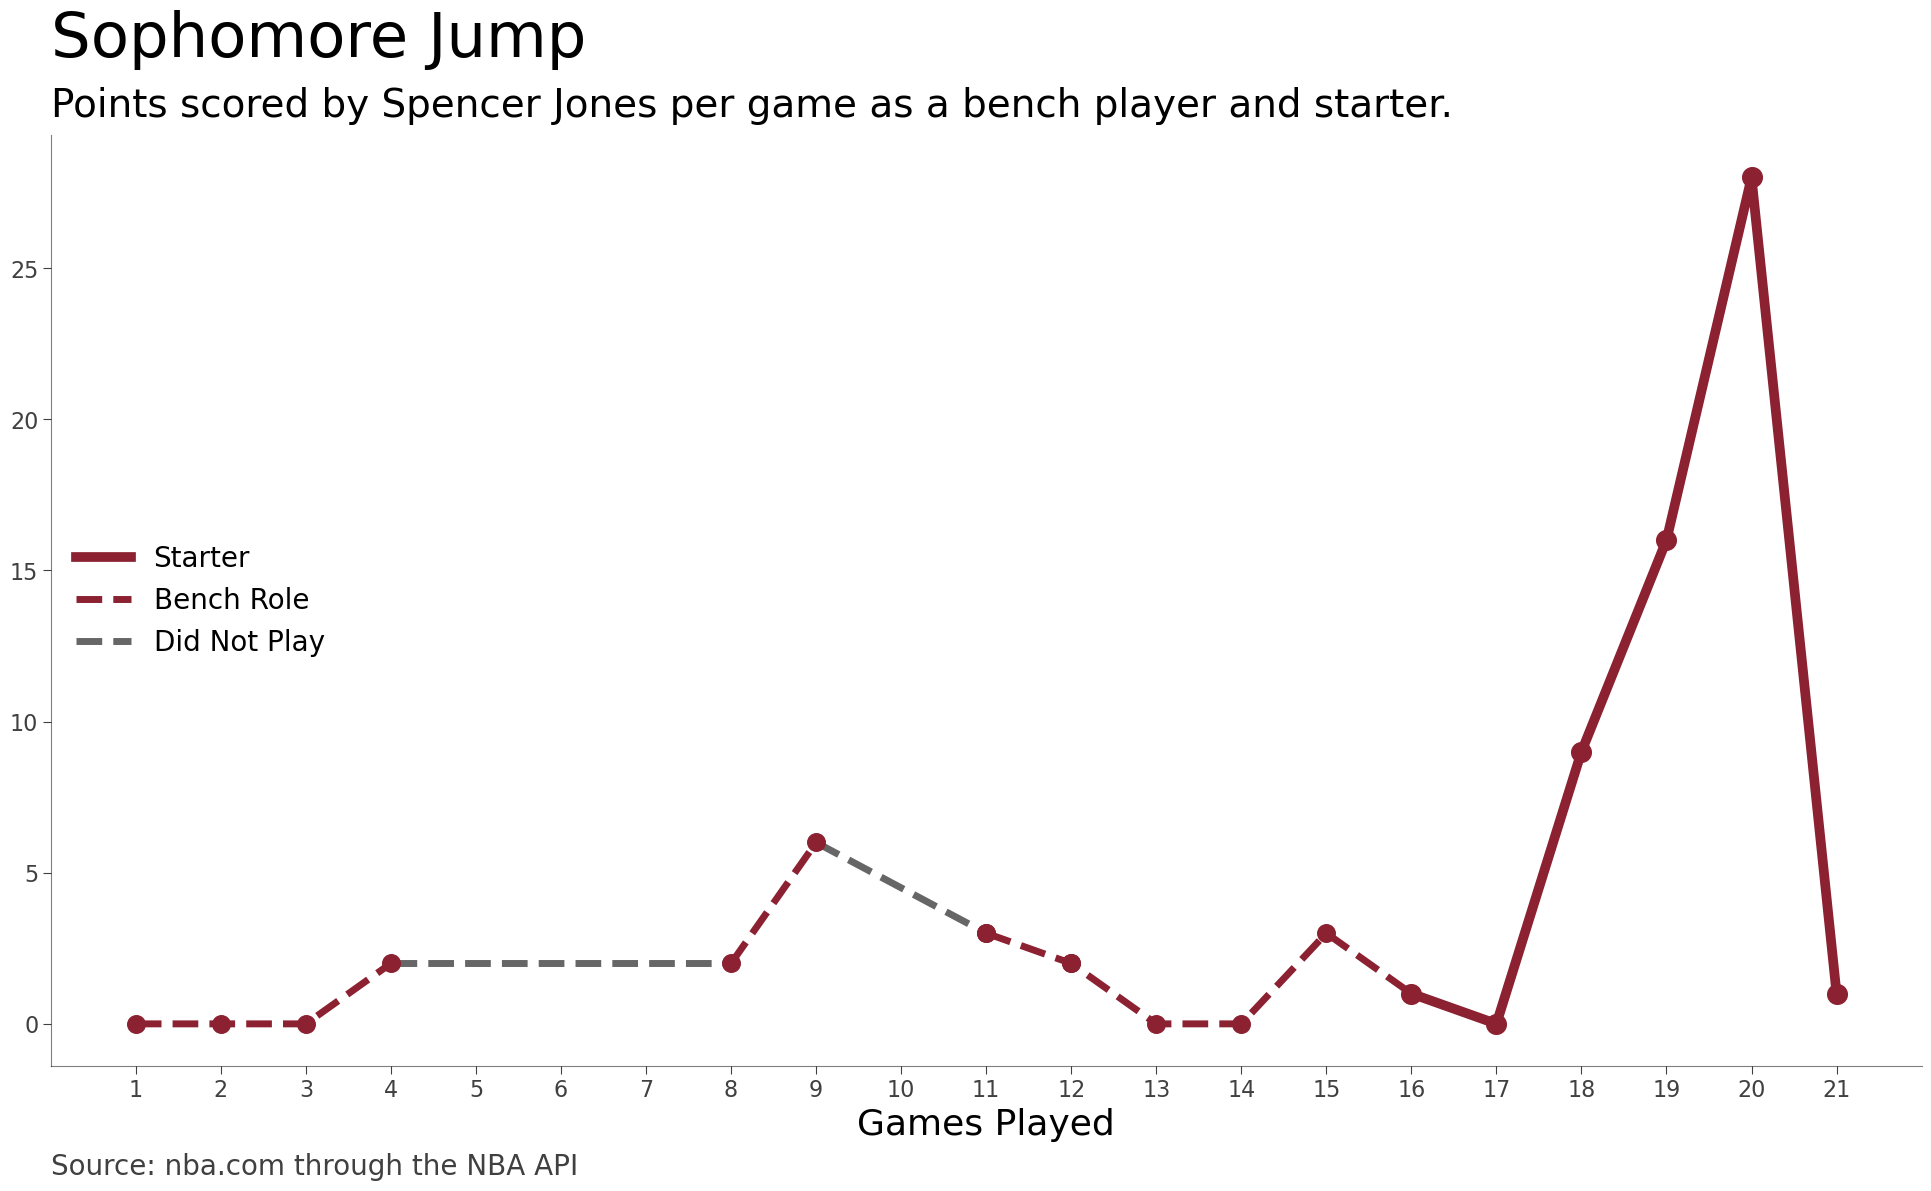

In [24]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))
ptsPerMin = dnpMask["points"]#/jonesBoxNugs["floatMinutes"]

ax.plot(dnpMask.index[-6:], ptsPerMin[-6:], color=FLATIRONS_RED, linewidth=7, linestyle="solid", label="Starter")
ax.scatter(dnpMask.index[-6:], ptsPerMin[-6:], marker="o", s=200, color=FLATIRONS_RED)

ax.plot(dnpMask.index[0:4], ptsPerMin[0:4], color=FLATIRONS_RED, linestyle="dashed", linewidth=5)
ax.scatter(dnpMask.index[0:4], ptsPerMin[0:4], color=FLATIRONS_RED, marker="o", s=160, zorder=3)

ax.plot(dnpMask.index[3:5], ptsPerMin[3:5], color='k', linestyle="dashed", linewidth=5, alpha=0.6)
ax.plot(dnpMask.index[4:6], ptsPerMin[4:6], color=FLATIRONS_RED, linestyle="dashed", linewidth=5, label="Bench Role")
ax.scatter(dnpMask.index[4:6], ptsPerMin[4:6], color=FLATIRONS_RED, marker="o", s=160, zorder=3)

ax.plot(dnpMask.index[5:7], ptsPerMin[5:7], color='k', linestyle="dashed", linewidth=5, alpha=0.6, label="Did Not Play")
ax.scatter(dnpMask.index[6:8], ptsPerMin[6:8], color=FLATIRONS_RED, marker="o", s=160, zorder=3)

ax.plot(dnpMask.index[6:12], ptsPerMin[6:12], color=FLATIRONS_RED, linestyle="dashed", linewidth=5)
ax.scatter(dnpMask.index[6:12], ptsPerMin[6:12], color=FLATIRONS_RED, marker="o", s=160, zorder=3)

# ax.plot(dnpMask.index[3:5], ptsPerMin[3:5], c=FLATIRONS_RED, linestyle="dotted", zorder=3)
# ax.scatter(dnpMask.index, ptsPerMin, color=FLATIRONS_RED, marker="o", s=160)


# X and Y tick labels
tidy_axes(ax)
ax.legend(frameon=False, fontsize=20, loc=6)
ax.set_xticks(jonesBoxNugs.index)
ax.set_xticklabels(jonesBoxNugs.index, fontsize=18)
ax.set_xlabel("Games Played", fontsize=26)
ax.tick_params(labelsize=16)

# Title and subtitle
ax.text(0, 32, "Sophomore Jump", fontsize=45)
ax.text(0, 30, r"Points scored by Spencer Jones per game as a bench player and starter.", fontsize=28)

# Footer
ax.text(0, -5, "Source: nba.com through the NBA API", fontsize=20, color=(0,0,0,.75))
plt.tight_layout()
# plt.savefig("jones_points.png")
plt.show()

---
## Now for the bars showing the lead margins

In [ ]:
from nba_api.stats.endpoints import PlayByPlayV3

In [ ]:
pbp = PlayByPlayV3(game_id="0022500006")

In [ ]:
pbp_df = pbp.get_data_frames()[0]

In [ ]:
# Game IDs for most recent home games against Bulls, Kings, Spurs, Mavs
gameIDs = {"Bulls":"0022500248", "Kings": "0022500274", "Spurs":"0022500076", "Mavericks":"0022500315"}

for team, gid in gameIDs.items():
    pbp = PlayByPlayV3(game_id=gid)
    
    df_pbp = pbp.get_data_frames()[0]
    
    df_pbp["Time"] = compute_time_axis(df_pbp["clock"], df_pbp["period"])
    
    df = df_pbp[["Time", "scoreHome", "scoreAway"]]
    
    # Remove blank entries (investigate what this is -- maybe for fouls or something)
    df = df[(df["scoreHome"] != "") & (df["scoreAway"] != "")]
    
    df.index = np.arange(1, len(df) + 1)
    
    df = df.astype(float)
    
    
    fig, ax = plt.subplots(figsize=(9,5))
    ax.plot(df["Time"], df["scoreHome"], color=MIDNIGHT_BLUE)
    ax.plot(df["Time"], df["scoreAway"], color="grey")
    
    diff = df["scoreHome"] - df["scoreAway"]
    
    indMaxLead = diff.idxmax()
    
    ax.vlines(df.loc[indMaxLead, "Time"], 0, 100)

    print(f"Biggest lead of {diff.loc[indMaxLead]} at {df.loc[indMaxLead, 'Time']:.2f}")
    
    plt.title(f"Against {team}.")
    plt.show()
    

In [ ]:
fig, ax = plt.subplots(figsize=(WIDTH, HEIGHT))

heights = [8, 13, 18, 17]
labels = ["Bulls", "Kings", "Spurs", "Mavericks"]
colors = ["#ce1141", "#5a2d81", "#c4ced4", "#00538c"]

bars =ax.bar(labels, heights, color=colors, alpha=1)

plt.ylabel("Value")

plt.bar_label(bars, fontsize=25)
tidy_axes(ax)
plt.yticks([])
plt.ylabel("Biggest Lead", fontsize=35)
plt.xticks(fontsize=36)


# Title and subtitle
ax.text(-.6, 21, "Letting the lead slip", fontsize=45)
ax.text(-.6, 20, r"Biggest lead held by the Denver Nuggets in four most recent home losses.", fontsize=28)

# Footer
ax.text(-.6, -2, "Source: nba.com through the NBA API", fontsize=20, color=(0,0,0,.75))
plt.tight_layout()
plt.savefig("bars.png")

plt.show()

In [ ]:
nuggetsGames

In [1]:
jamal_ppg = [18.571428571428573,
 14.826086956521738,
 17.94736842105263,
 17.4,
 17.88888888888889,
 25.045454545454547]